In [1]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# CSV-Datei laden
df = pd.read_csv("apartments_data_own_feature.csv")

# Features (X) und Zielvariable (y) festlegen
X = df[['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'neubau']]  # Ersetze "target" mit dem Namen der Zielspalte
y = df['price']  # Ersetze "target" mit der tatsächlichen Zielspalte

# Optional: Fehlende Werte überprüfen
print(df.isnull().sum())

# Optional: Erste Zeilen anzeigen
print(df.head())

print(df.dtypes)


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unnamed: 0         0
bfs_number         0
rooms              0
area               0
price              0
postalcode         0
address            0
town               0
description_raw    0
bfs_name           0
pop                0
pop_dens           0
frg_pct            0
emp                0
tax_income         0
lat                0
lon                0
x                  0
y                  0
room_per_m2        0
price_per_m2       0
luxurious          0
temporary          0
furnished          0
area_cat           0
area_cat_ecoded    0
(ATTIKA)           0
(LOFT)             0
(EXKLUSIV)         0
(SEESICHT)         0
(LUXURIÖS)         0
(POOL)             0
Kreis 6            0
Kreis 11           0
Kreis 12           0
Kreis 10           0
Kreis 4            0
Kreis 1            0
Kreis 9            0
Kreis 5            0
Kreis 7            0
Kreis 3            0
Kreis 2            0
Kreis 8            0
zurich_city        0
neubau             0
dtype: int64
   Unnamed: 0  bfs_nu

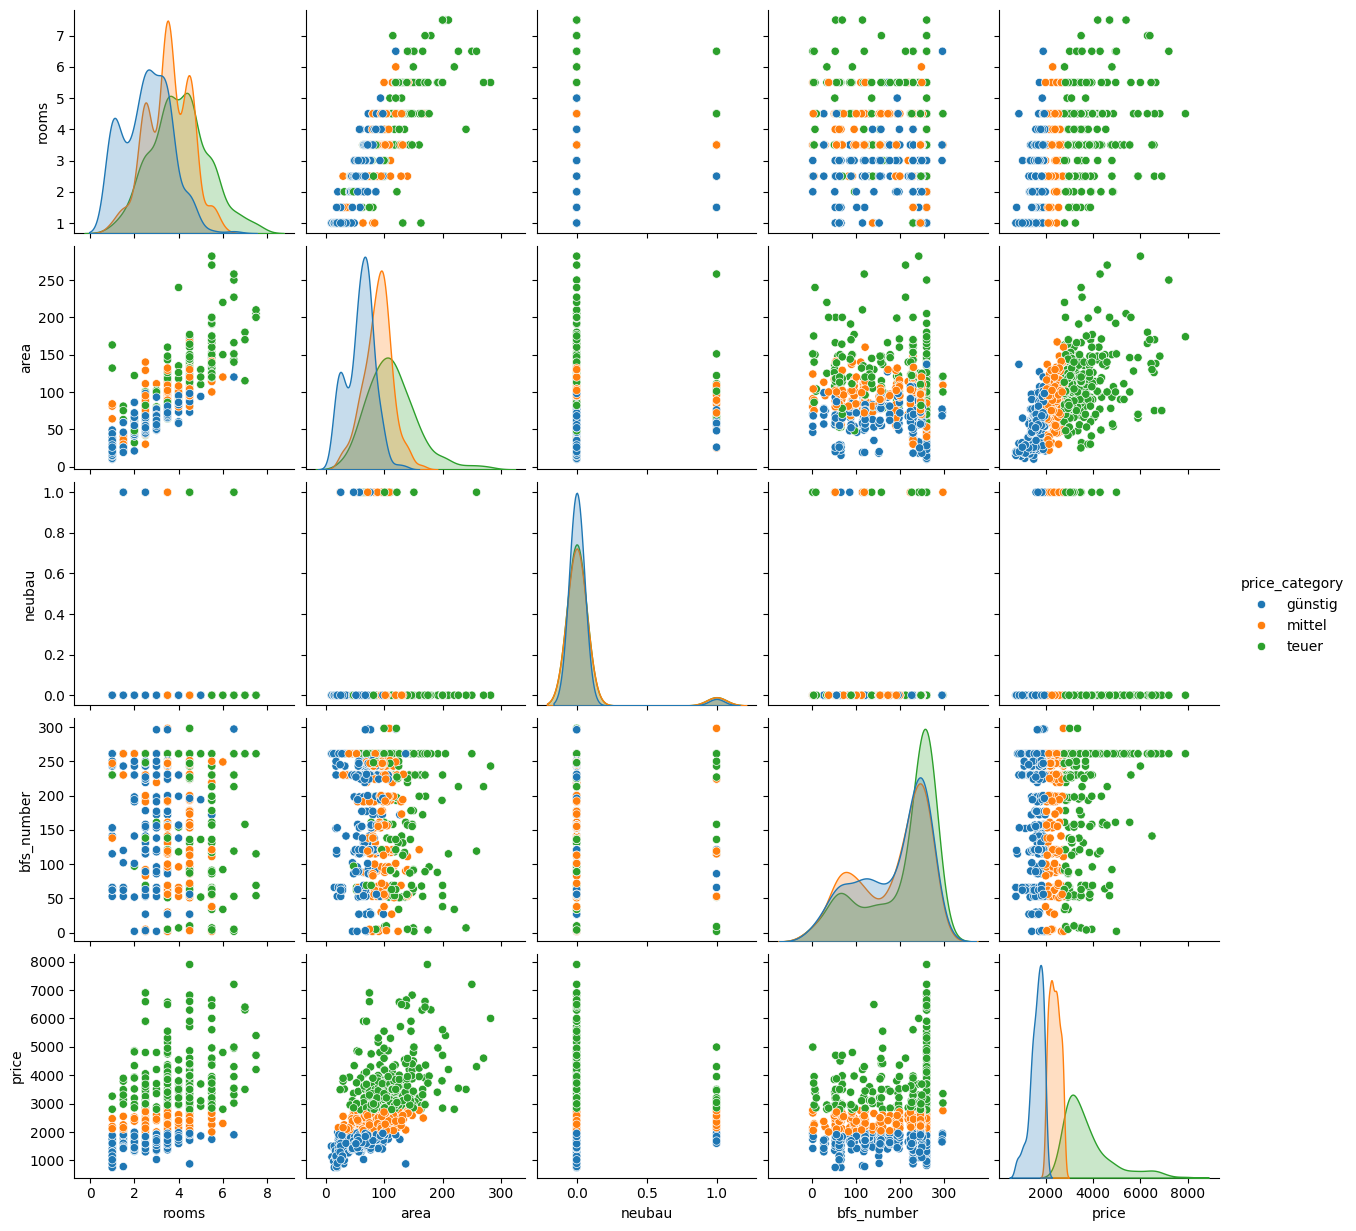

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Relevante Features für das Pairplot auswählen
features = ['rooms', 'area', 'neubau', 'bfs_number', 'price']
df_selected = df[features].copy()

# Preis in Kategorien umwandeln (z. B. in 3 Gruppen: günstig, mittel, teuer)
df_selected["price_category"] = pd.qcut(df_selected["price"], q=3, labels=["günstig", "mittel", "teuer"])

# Pairplot erstellen
sns.pairplot(df_selected, hue="price_category")
plt.show()

In [3]:
# Trainiere das Modell (Verwendung von RandomForestRegressor für Preisvorhersage)
model = RandomForestRegressor(random_state=42)
cross_val_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation accuracy: {np.mean(cross_val_scores):.4f}")

# Train on the full dataset
model.fit(X, y)
train_accuracy = model.score(X, y)
print(f"Training accuracy: {train_accuracy:.4f}")

Cross-validation accuracy: 0.5060
Training accuracy: 0.9431


In [4]:
# Gradio UI für Vorhersage
def predict(bfs_number, rooms, area, neubau):
    # Abrufen der Werte basierend auf der BFS-Nummer
    row = df[df['bfs_number'] == bfs_number]
    
    if row.empty:
        return "Fehler: BFS-Nummer nicht gefunden."
    
    # Werte aus der Zeile übernehmen
    pop = row['pop'].values[0]
    pop_dens = row['pop_dens'].values[0]
    frg_pct = row['frg_pct'].values[0]
    emp = row['emp'].values[0]
    tax_income = row['tax_income'].values[0]

    # Eingabewerte in ein DataFrame umwandeln
    input_data = pd.DataFrame([[rooms, area, pop, pop_dens, frg_pct, emp, tax_income, neubau]],
                              columns=['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'neubau'])
    
    # Vorhersage mit dem trainierten Modell
    prediction = model.predict(input_data)[0]  # Gibt den Preis als einzelne Zahl zurück
    return round(prediction, 2)  # Vorhersage auf 2 Dezimalstellen gerundet zurückgeben

In [5]:
predict(3, 119, 261, 1)

np.float64(4180.87)

In [52]:
# Gradio-Interface erstellen
demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Number(label="BFS Number"),
        gr.Number(label="Rooms"),
        gr.Number(label="Area"),
        gr.Checkbox(label="Neubau"),  # Checkbox für Neubau
    ],
    outputs="text",
    examples=[
        [51, 2, 50, False],  # Beispiel 1: Neubau = Nein
        [261, 3, 75, True],   # Beispiel 2: Neubau = Ja
        [118, 4, 100, False], # Beispiel 3: Neubau = Nein
    ],
    title="Apartment Price Prediction",
    description="Geben Sie die BFS-Nummer, Anzahl der Zimmer, Fläche und Neubau-Status ein, um den geschätzten Preis des Apartments zu erhalten."
)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7870
* Running on public URL: https://af5e2e103efd433825.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [50]:
import pickle

# save model to file
model_filename = "apartment_random_forest_regressor.pkl"
with open(model_filename, mode="bw") as f:
    pickle.dump(model, file=f)